In [34]:
The discrete convolution:
$$
\partial_t^\alpha (t_n) = \frac{1}{\tau^\alpha} \sum_{j=1}^{n+1} \omega_j^\alpha \Big[u(t_{n-j+1}) - u(0)  \Big]
$$
with 
<!-- $$ -->
<!-- \omega_0^\alpha = 1; \quad \omega_j^\alpha = - \frac{\alpha -j + 1}{j}, \quad j=1,\ldots . -->
<!-- $$ -->

$$
\omega_1^\alpha = 1; \quad \omega_j^\alpha = \frac{j-α-2}{j-1} ω_{j-1}^α, \quad j=2,\ldots .
$$

The following scheme is implemented:

$$
 \displaystyle \left(\frac{1}{τ^α} ω_1 M + A\right)u^n = f^n + \frac{1}{τ^α} \sum_{j=1}^{n} ω_j M u^1 - \frac{1}{τ^α} \sum_{j=2}^{n} ω_{n-j+1} M u^{j}
$$

LoadError: syntax: extra token "discrete" after end of expression

The discrete convolution:
$$
\partial_t^\alpha (t_n) = \frac{1}{\tau^\alpha} \sum_{j=1}^{n+1} \omega_j^\alpha \Big[u(t_{n-j+1}) - u(0)  \Big]
$$
with 
<!-- $$ -->
<!-- \omega_0^\alpha = 1; \quad \omega_j^\alpha = - \frac{\alpha -j + 1}{j}, \quad j=1,\ldots . -->
<!-- $$ -->

$$
\omega_1^\alpha = 1; \quad \omega_j^\alpha = \frac{j-α-2}{j-1} ω_{j-1}^α, \quad j=2,\ldots .
$$

The following scheme is implemented:

$$
 \displaystyle \left(\frac{1}{τ^α} ω_1 M + A\right)u^n = f^n + \frac{1}{τ^α} \sum_{j=1}^{n} ω_j M u^1 - \frac{1}{τ^α} \sum_{j=2}^{n} ω_{n-j+1} M u^{j}
$$

The problem:
\begin{align*}
  \partial_t^\alpha u -\nabla \cdot(A \nabla u) + {\bf b}\cdot \nabla u + c u &= f \quad \text{in}\; \Omega \times (0,T] \\
  u(x,t) &= 0 \quad \text{on}\; \partial \Omega \times (0,T]\\
  u(x,0) & = u_0(x) \quad \text{in } \; \Omega
\end{align*}
where $A=[a_{ij}(x)]_{1\le i,j\le2}$ is $2\times2$ symmetric and uniformly positive definite matrix.

For the mixed formulation: Consider $\sigma = -A\nabla u$ so that 
$$
A^{-1}{\boldsymbol{\sigma}} + \nabla u = 0, \qquad \text{and }\quad {\boldsymbol{b}\cdot \nabla u} = \beta \boldsymbol{\sigma}
$$
with $\beta = \boldsymbol{b}^T A^{-1}$. 

Mixed formulation is then defined as follows: Find $(u, \boldsymbol{\sigma}) \in V \times \boldsymbol{W}$ such that 
\begin{align*}
\left( \partial_t^\alpha u \cdot v\right) + \left(\nabla \cdot \boldsymbol{\sigma} , v\right) - (\beta \boldsymbol{\sigma}, v) + (cu, v) &= (f, v) \quad \forall v\in V\\
\left(A^{-1} \boldsymbol{\sigma},\boldsymbol{\tau} \right) - \left(u, \nabla \cdot \boldsymbol{\tau}\right) &=0\qquad\quad \forall \boldsymbol{\tau} \in \boldsymbol{W}
\end{align*}

In [41]:
module FractionalMixedFEM

using LinearAlgebra
using Printf
using Jacobi
using GradientRobustMultiPhysics
using ExtendableGrids
using GridVisualize
using ExtendableSparse
using SpecialFunctions

"""
    get_problem_data(ν)

TBW
"""
function get_problem_data(ϵ, p=1, α=1.0)
    γ= DataFunction([1.0]; name = "γ")
    β = DataFunction([1.0,2.0]; name = "β")    
    function exact!(result, x, t)
        result[1] = x[1]*t^p # x[1]*(1-x[1])*x[2]*(x[2]-1)*t# 1 + x[1]^2 + x[2]^2 + 1.2*t^3
     end
    
    u = DataFunction(exact!, [1,2]; name="u", dependencies="XT", bonus_quadorder=5)
    dt_u = eval_dt(u)
    ∇u = eval_∇(u)
    Δu = eval_Δ(u)
    function rhs!(result, x, t)    
        dt_u = x[1]*gamma(p+1)/gamma(p-α+1)*t^(p-α) 
        result[1] = dt_u-ϵ*Δu(x,t)[1] + dot(β(), ∇u(x,t))[1] + dot(γ(), u(x,t)[1]) # α * u(x,t)[1]
      return nothing
    end
    f = DataFunction(rhs!, [1,2]; name = "f", dependencies = "XT", bonus_quadorder = 5)
    return γ, β, u, ∇(u), f
  end

function main(;ϵ=1.0, nrefinements=2, nsteps=10, T0=0, Tf=1.0, α=1, tpower=1.0, verbosity=0)
    # generating fractional derivative data
    ω = zeros(nsteps+1)
    ω[1] = 1.0
    ω[2] = -α
    for j=3:nsteps+1
        ω[j] = (j-2-α)/(j-1)*ω[j-1]
    end
    # @show ω
    # computing the sum of ω
    sum_omega = zeros(nsteps+1)
    sum_omega[1] = ω[1]
    for j=2:nsteps+1
        sum_omega[j] = sum_omega[j-1] + ω[j]
    end
    # @show  sum_omega;
    
    ## finite elements and bilinear forms
    # Prepare the matrices and rhs coming from space discretization 
    ## set log level
    set_verbosity(verbosity)    
    # choose a finite element type

    FEType = [H1P1{1}, HDIVRT1{2}]
    #TODO: fix from the problem data
    u0 = DataFunction([0.0])

    ## negotiate data functions to the package
    γ, β, u, ∇u, f = get_problem_data(ϵ, tpower, α)

    function convection_kernel(result, input)
        # evaluate β
        eval_data!(β)
        # compute β ⋅ \sigma
            result[1] = 0.0
        for k = 1 : 2
            result[1] += β.val[k]*input[k]
        end
    end
    action = Action(convection_kernel, [1, 2]; dependencies = "", bonus_quadorder = β.bonus_quadorder) 
    CO = BilinearForm([Identity, Identity], action; factor = -1, transposed_assembly = true)

    ## load initial mesh
    #xgrid = grid_unitsquare(Triangle2D)
    xgrid = uniform_refine(grid_unitsquare(Triangle2D), nrefinements)
    FES = [FESpace{FEType[1]}(xgrid; broken = true), FESpace{FEType[2]}(xgrid)]
    # @show FES
    Solution = FEVector(FES)
    n_dofs = FES[1].ndofs + FES[2].ndofs
    interpolate!(Solution[1], u; time = 0.0)
    #@show Solution
    
    # matrices 
    M = FEMatrix(FES)
    assemble_operator!(M[1,1], BilinearForm([Identity, Identity]))
    # @show M.entries
    # println(size(M[1,1]))
    #println("ndofs: ", FES[1].ndofs)
    A = FEMatrix(FES)
    assemble_operator!(A[1,2], CO; time=0.0)
    assemble_operator!(A[1,1], ReactionOperator(γ); time=0.0)
    assemble_operator!(A[2,1], LagrangeMultiplier(Divergence); At = A[1,2]) 
    assemble_operator!(A[2,2], BilinearForm([Identity, Identity]; factor = 1/ϵ))
    # @show A.entries

    rhs = FEVector(FES)
    assemble_operator!(rhs[1], LinearForm(Identity, f); time=0.0)
    assemble_operator!(rhs[2], LinearForm(NormalFlux, u; AT=ON_BFACES); time=0.0)
    # @show rhs.entries
    
    t0 = T0
    tau = (Tf - T0)/nsteps
    @show nrefinements, nsteps

    V1 = zeros(Float64, FES[1].ndofs+FES[2].ndofs, 1)
    #V1 = FEVector(FES)
    Mu0 = zeros(Float64, FES[1].ndofs+FES[2].ndofs)

    SystemMatrix = FEMatrix(FES)
    # @show SystemMatrix
    SystemRHS = FEVector(FES)
    SystemSol = FEVector(FES)

    SolVector = Array{FEVector{Float64}}([])
    # ndofs
    SolVector = zeros(Float64, n_dofs, nsteps)
    SolVector[:,1] = Solution[1].entries

    @show norm(Solution.entries - SolVector[:,1])
    
    # time loop
    scale = tau^α
    l2 = zero(Float64); h1 = zero(Float64)
    oldL2 = zero(Float64); oldh1 = zero(Float64)
    eL2 = zero(Float64); eh1 = zero(Float64)

    Mu0[:] = M.entries*Solution.entries
    
    @show scale
    for m = 2:nsteps
        t0 = t0 + tau        
        # assemble rhs 
        fill!(SystemRHS.entries, 0)
        fill!(rhs.entries, 0)
        assemble_operator!(rhs[1], LinearForm(Identity, f); time=t0)
        assemble_operator!(rhs[2], LinearForm(NormalFlux, u; AT=ON_BFACES, factor = -1); time=t0)
        V1[:, 1] = rhs.entries

        fill!(SystemMatrix.entries.cscmatrix.nzval, 0)
        fill!(A.entries.cscmatrix.nzval, 0)
        # assembling the matrices with coefficients depending on time     
        assemble_operator!(A[1,1], ReactionOperator(γ); time=t0)
        assemble_operator!(A[1,2], CO; time=t0)
        assemble_operator!(A[2,1], LagrangeMultiplier(Divergence); At = A[1,2]) 
        assemble_operator!(A[2,2], BilinearForm([Identity, Identity]; factor = 1/ϵ))
        #@show t0, m, sum_omega[m]
        # system left hand side 1/τ^α * (M + A)u^n; ω_0= 1.0
        addblock!(SystemMatrix[1, 1], M[1, 1]; factor= ω[1]/scale)

        addblock!(SystemMatrix[1, 1], A[1, 1]; factor= 1.0)
        addblock!(SystemMatrix[1, 2], A[1, 2]; factor= 1.0)
        addblock!(SystemMatrix[2, 1], A[2, 1]; factor= 1.0)
        addblock!(SystemMatrix[2, 2], A[2, 2]; factor= 1.0)
        #@info "Preparing the rhs with right coefficients"
        # rhs at current time 
        addblock!(SystemRHS[1], V1[:,1]; factor= 1.0 )
        # 1/tau^α * ∑ ω_j^α M u^0 
        addblock!(SystemRHS[1], Mu0; factor= sum_omega[m]/scale)
        # @show sum_omega[m-1] # please check me once again
        # 1/τ^α * ∑_j=2^{n-1} ω_{n-j+1}^ℵ M u^j 
        for j=2:m-1 
            addblock!(SystemRHS[1], M.entries*SolVector[:,j]; factor= -ω[m-j+1]/scale)
        end

        flush!(SystemMatrix.entries)      
        #@show SystemRHS.entries

        SystemSol.entries[:] = SystemMatrix.entries \ SystemRHS.entries
        for j = 1 : n_dofs 
            Solution[1][j] = SystemSol[1][j]
        end

        # push!(SolVector, Solution)
        SolVector[:,m] = Solution[1].entries

        L2Error_u = L2ErrorIntegrator(u, Identity; time= t0)
        l2 = evaluate(L2Error_u, Solution[1])
        eL2 += (l2 + oldL2) * tau * 0.5
        oldL2 = l2

        h1erro = L2ErrorIntegrator(∇(u), Gradient; time= t0)
        h1 = evaluate(h1erro, Solution[1])
        eh1 += (l2 + oldh1) * tau * 0.5
        oldh1 = h1

        #@show sqrt(l2), sqrt(h1)
    end
    @show (sqrt(l2), sqrt(h1), sqrt(eL2), sqrt(eh1))
    (sqrt(l2), sqrt(h1), sqrt(eL2), sqrt(eh1))
end

end

Main.FractionalMixedFEM

In [53]:
ns = [10 20 40 80 160 320]
ns = [10 20 40 80 160 320]
eL2=[]; eH1=[]; eL2L2 =[]; eL2H1=[];
for n in ns
    el2, eh1, el2l2, el2h1 = Main.FractionalMixedFEM.main(;nrefinements=2, 
        T0 = 0, Tf=1, nsteps=n, α = 0.5)
    push!(eL2, el2)
    push!(eH1, eh1)
    push!(eL2L2, el2l2)
    push!(eL2H1, el2h1)
end

(nrefinements, nsteps) = (2, 10)
norm(Solution.entries - SolVector[:, 1]) = 0.0
scale = 0.31622776601683794
(sqrt(l2), sqrt(h1), sqrt(eL2), sqrt(eh1)) = (0.0002817551009787826, 0.0013383075189847033, 0.0004066816732059514, 0.0013843561859835435)
(nrefinements, nsteps) = (2, 20)
norm(Solution.entries - SolVector[:, 1]) = 0.0
scale = 0.22360679774997896
(sqrt(l2), sqrt(h1), sqrt(eL2), sqrt(eh1)) = (0.0001380725313814409, 0.00065572151226327, 0.00023000262249198874, 0.0007886039195742536)
(nrefinements, nsteps) = (2, 40)
norm(Solution.entries - SolVector[:, 1]) = 0.0
scale = 0.15811388300841897
(sqrt(l2), sqrt(h1), sqrt(eL2), sqrt(eh1)) = (6.838066372622981e-5, 0.00032471613736935364, 0.00012591787376151824, 0.0004329757638671768)
(nrefinements, nsteps) = (2, 80)
norm(Solution.entries - SolVector[:, 1]) = 0.0
scale = 0.11180339887498948
(sqrt(l2), sqrt(h1), sqrt(eL2), sqrt(eh1)) = (3.403795211256023e-5, 0.0001616246030724286, 6.755077289762501e-5, 0.000232631901192912)
(nrefinements, nste

L2: Any[0.0002817551009787826, 0.0001380725313814409, 6.838066372622981e-5, 3.403795211256023e-5, 1.6984424741823803e-5, 8.484772936983254e-6]
H1: Any[0.0013383075189847033, 0.00065572151226327, 0.00032471613736935364, 0.0001616246030724286, 8.064494259633999e-5, 4.0286016706532174e-5]


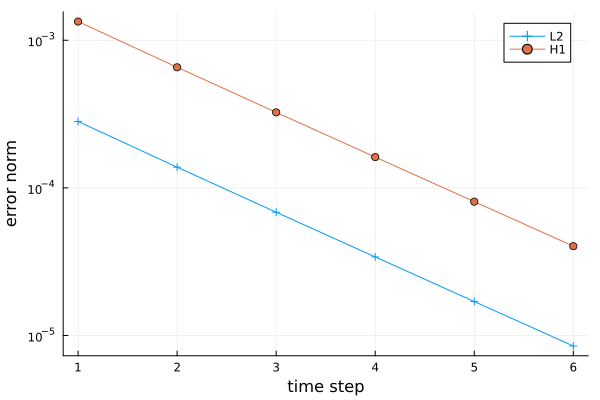

In [54]:
using Plots
println("L2: ", eL2)
println("H1: ", eH1)
taus = [ 1,2,3,4,5, 6]
plot(taus,[eL2 eH1],
    yaxis=:log10,
    label=["L2" "H1"],
    shape=:auto,
    xlabel="time step",ylabel="error norm")

L2: Any[0.0004066816732059514, 0.00023000262249198874, 0.00012591787376151824, 6.755077289762501e-5, 3.572067723058355e-5, 1.8681629830879233e-5]
H1: Any[0.0013843561859835435, 0.0007886039195742536, 0.0004329757638671768, 0.000232631901192912, 0.0001231477442312704, 6.446583823308432e-5]


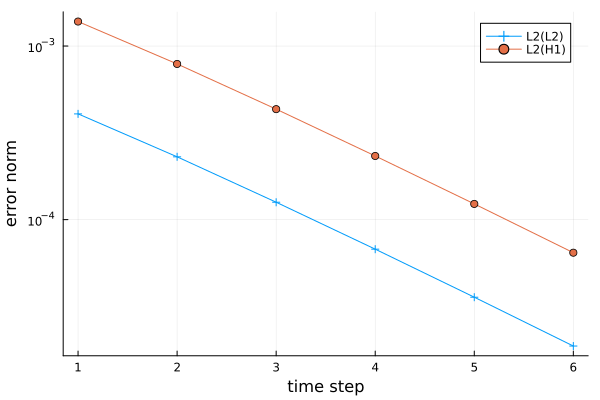

In [55]:
println("L2: ", eL2L2)
println("H1: ", eL2H1)
plot(taus,[eL2L2 eL2H1],
    yaxis=:log10,
    label=["L2(L2)" "L2(H1)"],
    shape=:auto,
    xlabel="time step",ylabel="error norm")